## RBC
The RBC models from the second version of the McKay exercises. The model is the same, it just is solved in a different way that leads better into sequence space Jacobian Methods.

#### Preliminaries

In [1]:
# load some packages
import matplotlib.pyplot as plt
import jax.numpy as jnp
import warnings
import jax
jax.config.update('jax_enable_x64', True)  # jax uses 32 bit numbers for some reason

# config
ALPHA = 1/3
BETA = 0.99
GAMMA = 2
DELTA = 0.1
L_BAR = 1.
RHO_Z = 0.8
SIGMA_Z = 0.02

#### The Model
The model is a simple planer problem with a representative household and competitive firm.

The household has preferences given by
$$
    \mathbb{E} \sum_{t=0}^\infty \beta^t \frac{C_t^{1-\gamma}}{1-\gamma}.
$$
The firm's production function is
$$
    Y_t = Z_t K_{t-1}^\alpha \overline L^{1-\alpha}.
$$
The aggregate resource constraint is
$$
    K_t + C_t = (1-\delta) K_{t-1} + Y_t.
$$
The FOCs of the production function get
\begin{align*}
    R_t &= \alpha Z_t K_{t-1}^{\alpha-1} \overline L^{1-\alpha} + 1 - \delta\tag{$K_{t-1}$} \\
    W_t &= (1-\alpha) Z_t K_{t-1}^{\alpha} \overline L^{-\alpha}. \tag{$\overline{L}$} \\
\end{align*}
Finally, setting up a Lagrangian for the household's preferences gets
$$
    \mathcal{L} = \mathbb{E} \sum_{t=0}^\infty \beta^t \left(\frac{C_t^{1-\gamma}}{1-\gamma} + \lambda_t \left((1-\delta) K_{t-1} + Z_t K_{t-1}^\alpha \overline L^{1-\alpha} - K_t - C_t\right)\right)
$$
which has the FOCs
\begin{align*}
    \lambda_t &= \beta \mathbb{E} \lambda_{t+1} \left(1 - \delta + \alpha Z_t K_{t}^{\alpha-1} \overline L^{1-\alpha} \right) \tag{$K_t$} \\
    \lambda_t &= C_t^{-\gamma}. \tag{$C_t$} \\
\end{align*}
which combined gets the Euler Equation
$$
    C_t^{-\gamma} = \beta \mathbb{E} R_{t+t} C_{t+1}^{-\gamma}.
$$

Finally, productivity follows the law of motion
$$
    \log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_{Z, t}
$$
where $\varepsilon_{Z, t} \sim \mathcal{N} (0, \sigma_Z)$.

| Variable | Meaning |
| --- | --- |
| $Y_t$ | Output at time $t$ |
| $C_t$ | Consumption at time $t$ |
| $K_t$ | Capital stock at time $t$ |
| $R_t$ | Rental rate of capital at time $t$ |
| $W_t$ | Wage at time $t$ |
| $Z_t$ | Productivity at time $t$ |

| Parameter | Meaning |
| --- | --- |
| $\alpha$ | Cobb-Douglas production parameter |
| $\beta$ | Discount rate |
| $\gamma$ | Risk aversion |
| $\delta$ | Capital deprecation |
| $\overline L$ | Labor supplied each period |
| $\rho_Z$ | Log productivity regression to mean |
| $\sigma_Z$ | Log productivity standard deviation |

In [2]:
# model equation
def residual(X_l, X_t, X_p, err):
    # unpack results
    _, _, K_l, _, _, Z_l = X_l
    Y_t, C_t, K_t, R_t, W_t, Z_t = X_t
    _, C_p, _, R_p, _, _ = X_p
    err_Z, = err

    # return residual array
    return jnp.array([
            Y_t - Z_t * K_l**ALPHA * L_BAR**(1-ALPHA),  # production function
            R_t - ALPHA * Z_t * K_l**(ALPHA-1) * L_BAR**(1-ALPHA) - 1 + DELTA,  # rental rate foc
            W_t - (1-ALPHA) * Z_t * K_l**ALPHA * L_BAR**(-ALPHA),  # wage foc
            K_t + C_t - (1-DELTA) * K_l - Y_t,  # agg resource constraint
            C_t**(-GAMMA) - BETA * R_p * C_p**(-GAMMA),  # euler equation
            jnp.log(Z_t) - RHO_Z * jnp.log(Z_l) - err_Z,  # production law of motion
        ])

#### Algebraic Steady State
In the steady state, we'll know $Z_{ss} = 1$. The Euler Equation gives us 
$$
    R_{ss} = \frac{1}{\beta}.
$$
That means capital is
$$
    K_{ss} = \left(\frac{R_{ss} + \delta - 1}{\alpha \overline L^{1-\alpha}}\right)^\frac{1}{\alpha-1}.
$$
Therefore, we know
\begin{align*}
    Y_{ss} &= K_{ss}^{\alpha} \overline L^{1-\alpha} \\
    C_{ss} &= Y_{ss} - \delta K_{ss} \\
    W_{ss} &= (1-\alpha) K_{ss}^\alpha \overline L^{-\alpha}
\end{align*}

In [3]:
# variable steady states
Z_ss = 1
R_ss = 1 / BETA
K_ss = ((R_ss + DELTA - 1) / ALPHA / L_BAR**(1-ALPHA))**(1/(ALPHA-1))
Y_ss = K_ss**ALPHA * L_BAR**(1-ALPHA)
C_ss = Y_ss - DELTA * K_ss
W_ss = (1-ALPHA) * K_ss**ALPHA * L_BAR**(-ALPHA)

# array
X_ss = jnp.array([Y_ss, C_ss, K_ss, R_ss, W_ss, Z_ss])
err_ss = jnp.zeros(1)

# check our answer
assert jnp.allclose(residual(X_ss, X_ss, X_ss, err_ss), 0)

#### Computational Steady State
We can also use a Newton's method on to solve for the steady state, which gets the same answer.

To do this, we'll define a residual function $f$ such that
$$
    f(\vec X_{t-1}, \vec X_t, \vec X_{t+1}, \varepsilon_t) = \vec 0
$$
where
$$
    \vec X_t = \begin{pmatrix} Y_t \\ C_t \\ K_t \\ R_t \\ W_t \\ Z_t \end{pmatrix}.
$$

In [4]:
# helper function
def newtons_zeros(F, x0, tol=1e-10, maxiter=1000):
    '''
    Uses Newton's method to find zeros of a higher dimensional function
    '''
    # get derivative function
    jac = jax.jacfwd(F)

    # update rule
    # jit makes the first iteration take longer, but the ones after that are much faster
    # typically, this has a benifit only for large problems
    @jax.jit
    def q(X):
        return X - jnp.linalg.solve(jac(X), F(X))

    # initial conditions
    X = X_l = x0  # x0 has to be defined so we know the sixe of inputt
    for _ in range(maxiter):
        # update rule
        X, X_l = q(X), X

        # exit condition
        if jnp.abs(X - X_l).max() < tol:
            break
    else:
        warnings.warn('Max iteration count exceeded')
    
    return X

# solve 
resid_ss = lambda X_ss: residual(X_ss, X_ss, X_ss, err_ss)  # steady state has X_l = X_t = X_p
calc_X_ss = newtons_zeros(resid_ss, jnp.ones(6))

# check the answer
assert jnp.allclose(calc_X_ss, X_ss)

#### Shocks
To calculate an impulse response after a shock $\varepsilon$ at time $0$, we want to find $\{Y_t, C_t, K_t, R_t, W_t, Z_t\}_{t=0}^\infty$. Since over time the economy gets closer and closer to the steady state, we can assume the economy is back to normal after some large $T$ and only solve for $\{Y_t, C_t, K_t, R_t, W_t, Z_t\}_{t=0}^T$. Since the time horizon is now finite, we can define $\vec X = \{\vec X_t\}_{t=0}^T$ and $\varepsilon = \{\varepsilon_t\}_{t=0}^T$ to setup a function $F$ where
$$
    F(X, \varepsilon) = \begin{pmatrix}
        f(X_{ss}, X_0, X_1, \varepsilon_0) \\
        f(X_0, X_1, X_2, \varepsilon_1) \\
        f(X_1, X_2, X_3, \varepsilon_2) \\
        \vdots \\
        f(X_{T-2}, X_{T-1}, X_T, \varepsilon_{T-1}) \\
        f(X_{T-1}, X_T, X_{ss}, \varepsilon_T) \\
        \end{pmatrix}
$$
and solve for the zeros.

This does create a perfect foresight version of the economy, which means risk premiums don't exist, but that gets the same result as a linearization around the steady state.

In [5]:
# config
T = 300
long_X_ss = jnp.hstack([X_ss for _ in range(T)])  # steady state over the whole time
long_err_ss = jnp.zeros(T)
long_err = jnp.zeros(T).at[0].set(SIGMA_Z)  # shock we'll simulate

# residual over a period of time
def long_residual(X, err, X_ss=X_ss):
    # config
    X = X.reshape(-1, 6)  # X[t] = X_t
    err = err.reshape(-1, 1)  # err[t] = err_t (as a vector)
    T = X.shape[0]  # 1 is number of vars (6)

    # calcualte residuals
    res = [residual(X_ss, X[0], X[1], err[0])]
    for t in range(1, T-1):
        res.append(residual(X[t-1], X[t], X[t+1], err[t]))
    res.append(residual(X[-2], X[-1], X[t+1], err[-1]))

    return jnp.hstack(res)  # turn into one vector

assert jnp.allclose(long_residual(long_X_ss, long_err_ss), 0)

#### Linear Solution
To solve this with a linear approximation, we can take a Jacobian around the steady state with respect to the $\varepsilon$ and $\vec X$. Then, we know
$$
    F_{\vec X} (X_{ss}, \varepsilon_{ss}) (X - X_{ss}) + F_{\varepsilon} (X_{ss}, \varepsilon_{ss}) (\varepsilon - \varepsilon_{ss}) = \vec 0.
$$

This can be rewritten as
$$
    \vec X = X_{ss} - F_{\vec X} (X_{ss}, \varepsilon_{ss})^{-1} F_{\varepsilon} (X_{ss}, \varepsilon_{ss}) (\varepsilon - \varepsilon_{ss})
$$
which gives us a solution to the IRF.

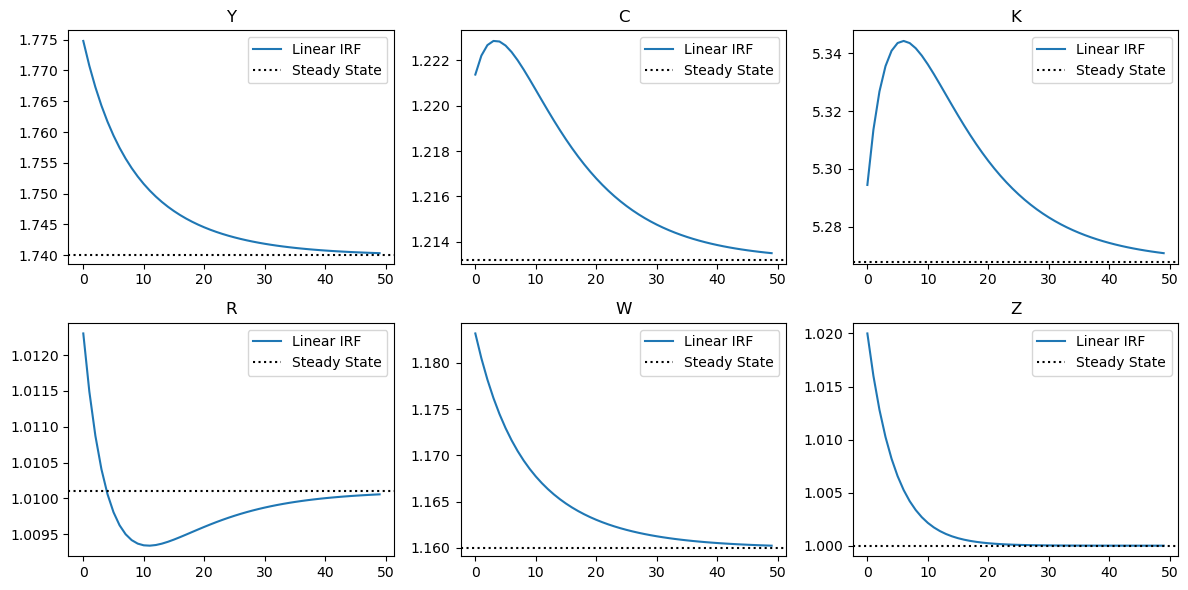

In [6]:
# get jacobians
jac_long_X = jax.jacfwd(lambda X: long_residual(X, long_err_ss))(long_X_ss)
jac_long_err = jax.jacfwd(lambda err: long_residual(long_X_ss, err))(long_err_ss)

# solve for X
linear_irf = long_X_ss - jnp.linalg.solve(jac_long_X, jac_long_err) @ (long_err - long_err_ss)
linear_irf = linear_irf.reshape(6, -1, order='F')  # linear_irf[i] is the path for a variable 

# plot it
t = 50
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
titles = ['Y', 'C', 'K', 'R', 'W', 'Z']
for i in range(6):
    ax = axs.take(i)
    ax.plot(linear_irf[i, :t], label='Linear IRF')
    ax.axhline(X_ss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
fig.tight_layout()

#### Nonlinear Solution
We can also use Newton's Method to solve for zeros to $F$. This is more accurate, since it's not a linear approximation, but does mean we're assuming perfect foresight.

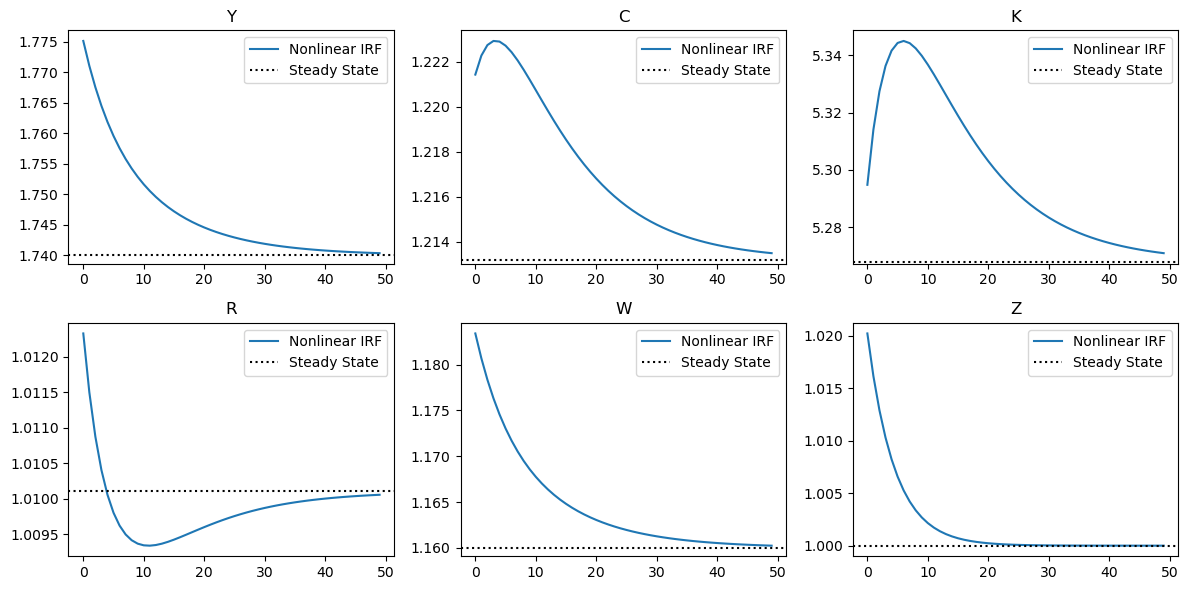

In [7]:
# calculate irf
irf_func = lambda X: long_residual(X, long_err)
nonlinear_irf = newtons_zeros(irf_func, long_X_ss, tol=1e-14)
nonlinear_irf = nonlinear_irf.reshape(6, -1, order='F')  # nonlinear_irf[i] is the path for a variable 

# plot it
t = 50
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
titles = ['Y', 'C', 'K', 'R', 'W', 'Z']
for i in range(6):
    ax = axs.take(i)
    ax.plot(nonlinear_irf[i, :t], label='Nonlinear IRF')
    ax.axhline(X_ss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
fig.tight_layout()

#### Comparison
The two estimates are fairly similar, but do differ slightly.

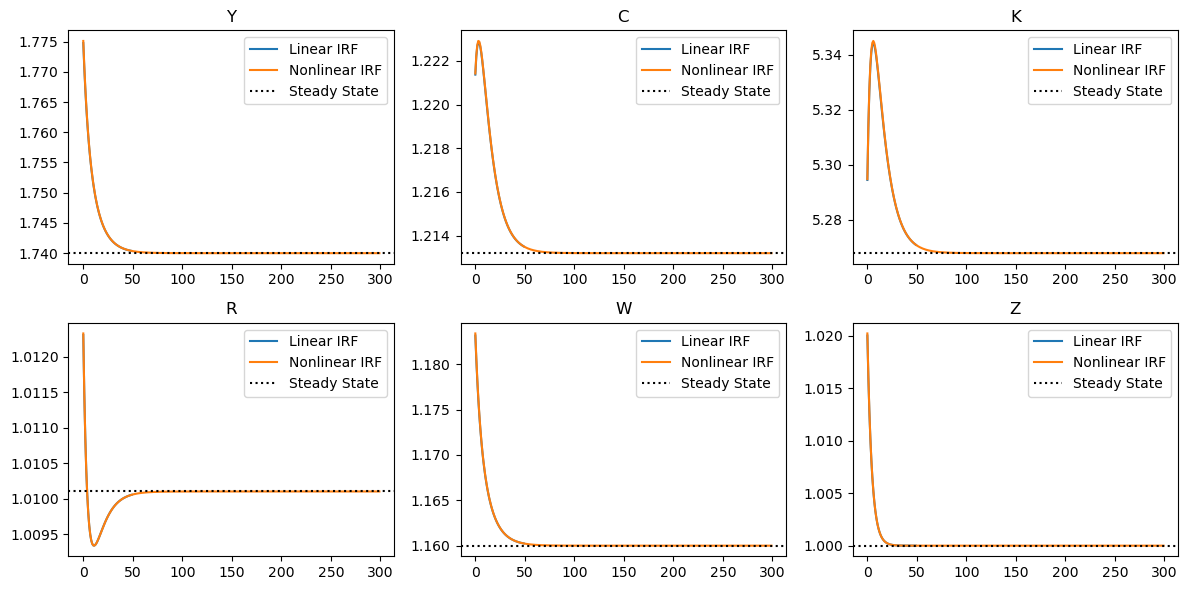

In [8]:
# plot it
t = 50
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
titles = ['Y', 'C', 'K', 'R', 'W', 'Z']
for i in range(6):
    ax = axs.take(i)
    ax.plot(linear_irf[i, :t], label='Linear IRF')
    ax.plot(nonlinear_irf[i], label='Nonlinear IRF')
    ax.axhline(X_ss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
fig.tight_layout()